In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Ant?nio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [3]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [4]:
from langchain_openai import ChatOpenAI
from os import getenv

llm = ChatOpenAI(
  openai_api_key=getenv("OPENROUTER_API_KEY"),
  openai_api_base="https://openrouter.ai/api/v1",
  model_name="google/gemini-2.0-flash-exp:free",
)

In [5]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F561A556A0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001F561A57260>, root_client=<openai.OpenAI object at 0x000001F560DD0BC0>, root_async_client=<openai.AsyncOpenAI object at 0x000001F561A55700>, model_name='google/gemini-2.0-flash-exp:free', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://openrouter.ai/api/v1')

In [6]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

c:\Users\mdmem\miniconda3\envs\nl2sql\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [7]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [8]:
db.get_table_info()

'\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEG

In [10]:
write_query({"question": "How many Employees are there?"})

TypeError: 'NoneType' object is not iterable

In [ ]:
write_query({"question": "직원이 몇명이지?"})

{'query': 'SELECT COUNT(*) FROM Employee'}

In [ ]:
write_query({"question": "앨범 타이틀과 가수 이름 목록 알려줘?"})

{'query': 'SELECT T1.Title, T2.Name FROM Album AS T1 INNER JOIN Artist AS T2 ON T1.ArtistId = T2.ArtistId LIMIT 10'}

In [ ]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [ ]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

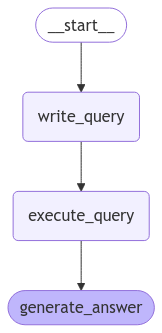

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT count(*) FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.\n'}}


In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000026BFB161010>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000026BFB161010>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000026BFB161010>),
 QuerySQLCheckerTool(description='Use this tool to 

In [ ]:
# toolkit의 모든 도구 정보 출력
for tool in toolkit.get_tools():
    print(f"\nTool: {tool.__class__.__name__}")
    print(f"Description: {tool.description}")
    if hasattr(tool, 'llm_chain') and hasattr(tool.llm_chain, 'prompt'):
        print("\nPrompt Template:")
        print(tool.llm_chain.prompt.template)



Tool: QuerySQLDatabaseTool
Description: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

Tool: InfoSQLDatabaseTool
Description: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

Tool: ListSQLDatabaseTool
Description: Input is an empty string, output is a comma-separated list of tables in the database.

Tool: QuerySQLCheckerTool
Description: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!

Prompt Template:

{query}
Dou

In [14]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

c:\Users\mdmem\miniconda3\envs\nl2sql\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [15]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [16]:
llm = ChatOpenAI(
  openai_api_key=getenv("OPENAI_API_KEY"),
  model_name="gpt-4o-mini",
)


In [17]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F55E520EF0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F55E520EF0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F55E520EF0>),
 QuerySQLCheckerTool(description='Use this tool to 

In [18]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [19]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_BHgZ2Zi45DmLrk5n8GY8E056)
 Call ID: call_BHgZ2Zi45DmLrk5n8GY8E056
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_BxdTdWzSWGhqmXR1pTU34wSX)
 Call ID: call_BxdTdWzSWGhqmXR1pTU34wSX
  Args:
    table_names: Customer
  sql_db_schema (call_GVqstItNs2EgxCdwGRzwAmUf)
 Call ID: call_GVqstItNs2EgxCdwGRzwAmUf
  Args:
    table_names: Invoice
  sql_db_schema (call_j73CWiKHTCksEBT5Ms7mPLeB)
 Call ID: call_j73CWiKHTCksEBT5Ms7mPLeB
  Args:
    table_names: InvoiceLine
========

In [22]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="all",  # "values" 대신 "all"을 사용
):
    # 각 step의 input 메시지 출력
    print(step, flush=True)

In [23]:
print("test")

test
